In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Determine sex by chrY UMIs

In [8]:
d = pd.read_csv("results/seurat_transcripts/metadata_and_celltype.consistent_celltype.tsv", sep="\t")
array = []
for run, cell in d[["Run", "Cell"]].values:
    path = "../../1_NanoNASCseq/results/mapping/chrom_reads/%s/%s.tsv" % (run, cell)
    m = pd.read_csv(path, sep="\t", header=None, index_col=0)
    m.index.name = "Chrom"
    m.columns = [cell]
    array.append(m)
    # break

In [13]:
d = pd.concat(array, axis=1)
d = d.divide(d.sum(axis=0), axis=1)

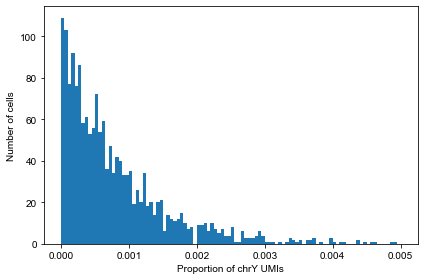

In [27]:
ys = d.loc["chrY"]

plt.figure()
plt.hist(ys, bins=100, range=(0, 0.005))
plt.xlabel("Proportion of chrY UMIs")
plt.ylabel("Number of cells")
plt.tight_layout()
plt.show()

# Determine sex by paternal allele

In [33]:
anno = pd.read_csv("results/mouse_transcript_annotation.tsv", sep="\t", index_col=0)
anno.head()

,TranscriptName,TranscriptType,GeneID,GeneName,GeneType,Chrom,Start,End,Strand
TranscriptID,,,,,,,,,
ENSMUST00000193812.1,4933401J01Rik-201,TEC,ENSMUSG00000102693.1,4933401J01Rik,TEC,chr1,3073252,3074322,+
ENSMUST00000082908.1,Gm26206-201,snRNA,ENSMUSG00000064842.1,Gm26206,snRNA,chr1,3102015,3102125,+
ENSMUST00000162897.1,Xkr4-203,processed_transcript,ENSMUSG00000051951.5,Xkr4,protein_coding,chr1,3205900,3216344,-
ENSMUST00000159265.1,Xkr4-202,processed_transcript,ENSMUSG00000051951.5,Xkr4,protein_coding,chr1,3206522,3215632,-
ENSMUST00000070533.4,Xkr4-201,protein_coding,ENSMUSG00000051951.5,Xkr4,protein_coding,chr1,3214481,3671498,-


In [71]:
def parse_alleles(x):
    counter = dict()
    if isinstance(x, str):
        for item in x.split(";"):
            k, n = item.split(":")
            n = int(n)
            snp = k[:-2]
            if k[-1] == k[-5]:
                hp = 1
            elif k[-1] == k[-3]:
                hp = 2
            else:
                assert False
            if snp not in counter:
                counter[snp] = [0, 0]
            counter[snp][hp-1] += n
    elif np.isnan(x):
        pass
    else:
        assert False
    return counter

info = pd.read_csv("results/seurat_transcripts/metadata_and_celltype.consistent_celltype.tsv", sep="\t")

rows1 = []
for run, cell in info[["Run", "Cell"]].values:
    
    infile = "../../1_NanoNASCseq/results/expression/novel/quant_isoforms/min_read_1_min_tc_1/%s/%s.tsv" % (run, cell)
    
    d = pd.read_csv(infile, sep="\t", index_col=0)
    rows = []
    for tname, (a1, a2) in zip(d.index, d[["Total.Alleles", "Nascent.Alleles"]].values):
        counter1 = parse_alleles(a1)
        counter2 = parse_alleles(a2)
        if len(counter1) > 0:
            snps = counter1.keys()
            for snp in snps:
                total_hp1, total_hp2 = counter1[snp]
                nascent_hp1, nascent_hp2 = 0, 0
                if snp in counter2:
                    nascent_hp1, nascent_hp2 = counter2[snp]
                rows.append([tname, snp, total_hp1, total_hp2, nascent_hp1, nascent_hp2])
                
    m = pd.DataFrame(rows)
    m.columns = ["TranscriptID", "Snp", "Total.HP1", "Total.HP2", "Nascent.HP1", "Nascent.HP2"]
    m["Total.All"] = m["Total.HP1"] + m["Total.HP2"]
    m = m.sort_values(by="Total.All", ascending=False)
    m = m[~m["TranscriptID"].duplicated()]
    m.index = m["TranscriptID"]
    m = m.merge(anno, left_index=True, right_index=True)
    m = m[m["Chrom"] == "chrX"]
    
    v1, v2 = m["Total.HP1"].sum(), m["Total.HP2"].sum()
    # r = np.divide(v2, (v1 + v2))
    rows1.append([cell, v1, v2])
    # print(v1, v2, r, cell, sep="\t")
    
    # break

In [72]:
d = pd.DataFrame(rows1, columns=["Cell", "HP1", "HP2"])
d["All"] = d["HP1"] + d["HP2"]
d["HP2.Ratio"] = d["HP2"] / d["All"]

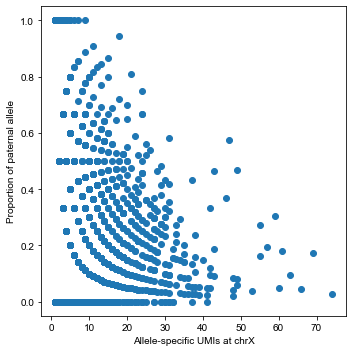

In [73]:
plt.figure(figsize=(5, 5))
plt.scatter(d["All"], d["HP2.Ratio"])
plt.xlabel("Allele-specific UMIs at chrX")
plt.ylabel("Proportion of paternal allele")
plt.tight_layout()
plt.show()
plt.close()

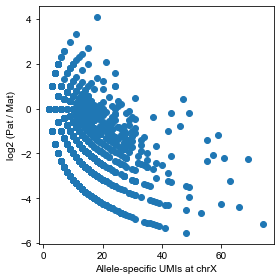

In [76]:
plt.figure(figsize=(4, 4))
plt.scatter(d["All"], np.log2(np.divide(d["HP2"], d["HP1"])))
plt.xlabel("Allele-specific UMIs at chrX")
plt.ylabel("log2 (Pat / Mat)")
plt.tight_layout()
plt.show()
plt.close()

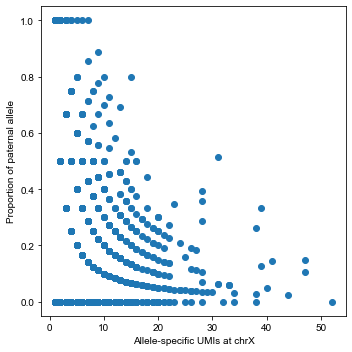

In [68]:
plt.figure(figsize=(5, 5))
plt.scatter(d["All"], d["HP2.Ratio"])
plt.xlabel("Allele-specific UMIs at chrX")
plt.ylabel("Proportion of paternal allele")
plt.tight_layout()
plt.show()
plt.close()